<a href="https://colab.research.google.com/github/khalidmeister/trmm-downscaling/blob/main/code_downscaling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download Data

## Download TRMM

In [ ]:
files = []

for i in range(2010, 2015+1):
  for j in range(1, 12+1):
    if j < 10 and i == 2010:
      files.append("https://disc2.gesdisc.eosdis.nasa.gov/data/TRMM_L3/TRMM_3B43.7/" + str(i) + "/3B43." + str(i) + "0" + str(j) + "01.7A.HDF\n")
    elif j > 10 and i == 2010:
      files.append("https://disc2.gesdisc.eosdis.nasa.gov/data/TRMM_L3/TRMM_3B43.7/" + str(i) + "/3B43." + str(i) + str(j) + "01.7.HDF\n")
    elif j < 10 and i > 2010:
      files.append("https://disc2.gesdisc.eosdis.nasa.gov/data/TRMM_L3/TRMM_3B43.7/" + str(i) + "/3B43." + str(i) + "0" + str(j) + "01.7.HDF\n")
    else:
      files.append("https://disc2.gesdisc.eosdis.nasa.gov/data/TRMM_L3/TRMM_3B43.7/" + str(i) + "/3B43." + str(i) + str(j) + "01.7.HDF\n")

with open("trmm.txt", "w+") as f:
  f.writelines(files)
  f.close()

# DEBUG ONLY
# with open("trmm.txt", "r") as f:
#   for i in f.readlines():
#     print(i)

! wget --content-disposition --load-cookies ~/.urs_cookies --save-cookies ~/.urs_cookies --keep-session-cookies --user=irfan_1_khalid --ask-password --content-disposition -i trmm.txt

In [68]:
! mv *.HDF trmm/

In [100]:
! cp -R trmm/ /content/drive/MyDrive/projects/spatial-downscaling-precipitation/data

## Download MODIS

# Preprocess the Data

In [95]:
import re
import os
import numpy as np
import matplotlib.pyplot as plt
from osgeo import gdal

root = "trmm"

files = []

for i in sorted(os.listdir(root)):
  if re.match(r'.*\.2010.*', i):
    file_ = os.path.join('trmm', i)
    data = gdal.Open(file_, gdal.GA_ReadOnly)
    dataset = data.GetSubDatasets()[0]
    precip = gdal.Open(dataset[0], gdal.GA_ReadOnly)
    precip = precip.ReadAsArray().T
    files.append(precip)

files = np.array(files)
precip_annual = np.average(files, axis=0)
print(precip_annual.shape)

(400, 1440)


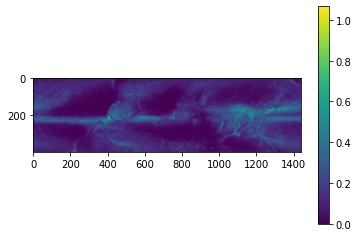

In [96]:
plt.imshow(precip_annual)
plt.colorbar()
plt.show()